In [1]:
import os
import time
import copy
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

from models import *
from utils import *
from datasets import *

# generate imgs

In [8]:
# MM_I_wPATH="./results/231017173718_I_3/DR_weights_I_3.pt"
# MM_II_wPATH="./results/231017172646_II_3/HM_weights_II_3.pt"

# dir_PATH = "./results/231024172445/"
# # MM_I_wPATH = "./results/231024172445/I-1/DR_weights_I-1.pt"
# # MM_II_wPATH = "./results/231024172445/II-1/HM_weights_II-1.pt"
# MM_I_wPATH = "./results/231024172445/I-2/DR_weights_I-2.pt"
# MM_II_wPATH = "./results/231024172445/II-2/HM_weights_II-2.pt"

# dir_PATH = "./results/231031212002/"
# MM_I_wPATH = "./results/231031212002/I-3/DR_weights_I-3.pt"
# MM_II_wPATH = "./results/231031212002/II-3/HM_weights_II-3.pt"

# dir_PATH = "./results/231111143334/"
# MM_I_wPATH = "./results/231111143334/I-1/DR_weights_epoch0.pt"
# MM_II_wPATH = "./data/pretrain_results/HM_weights_ord.pt" # "./results/231111123134/II-3/HM_weights_epoch0.pt"

# dir_PATH = "./results/231116224941/"
# MM_I_wPATH = "./results/231116224941/I-1/DR_weights_epoch0.pt"
# MM_II_wPATH = "./data/pretrain_results/HM_weights_ce.pt"

# dir_PATH = "./results/231116232334/"
# MM_I_wPATH = "./results/231116232334/I-1/DR_weights_epoch3.pt"
# MM_II_wPATH = "./data/pretrain_results/HM_weights_ce.pt"

# dir_PATH = "./results/231117005348/"
# # MM_I_wPATH = "./results/231117005348/I-1/DR_weights_epoch59.pt"
# MM_I_wPATH = "./results/231117005348/I-1/DR_weights_best.pt"
# MM_II_wPATH = "./data/pretrain_results/HM_weights_ce.pt"

dir_time = "231116224941"

dir_PATH = "./results/{}/".format(dir_time)
MM_I_wPATH = "./results/{}/I-1/DR_weights_epoch4.pt".format(dir_time)
MM_II_wPATH = "./data/pretrain_results/HM_weights_ce.pt"

save_path = "./results/{}/".format(dir_time)
os.makedirs(save_path, exist_ok=True)

model = MMModel(
        MM_I_wPATH=MM_I_wPATH, 
        MM_II_wPATH=MM_II_wPATH, 
        freeze=(True, True), 
        device=torch.device('cuda')
    )
model.eval()

loading MM_I weights from ./results/231116224941/I-1/DR_weights_epoch4.pt
loading MM_II weights from ./data/pretrain_results/HM_weights_ce.pt


MMModel(
  (MM_I): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=4608, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (MM_II): HumanModel(
    (cnn): ResNet(
      (conv1): Sequential(
        (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2_x): Sequential(
        (0): BasicBlock(
          (residual_function): Sequential(
            (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [9]:
train_loss = torch.load("./results/231116224941/I-1/train_losses_I-1.pt")
eval_loss = torch.load("./results/231116224941/I-1/eval_losses_I-1.pt")
eval_loss, train_loss

(tensor([[0.1738, 0.2138],
         [0.1736, 0.1764],
         [0.1742, 0.1784],
         [0.1727, 0.1632],
         [0.1744, 0.1589]], dtype=torch.float64),
 tensor([[0.1218, 0.2594],
         [0.1234, 0.1400],
         [0.1248, 0.1249],
         [0.1241, 0.1265],
         [0.1240, 0.1154]], dtype=torch.float64))

In [4]:
from torch.utils.data import DataLoader, TensorDataset

# data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

X_train = [i[0].unsqueeze(0) for i in trainset]
X_train = torch.vstack(X_train)
y_train = torch.tensor([i[1] for i in trainset])
print("X_train.shape: {}".format(X_train.shape))        # X_train.shape: torch.Size([60000, 1, 28, 28])

X_test = [i[0].unsqueeze(0) for i in testset]
X_test = torch.vstack(X_test)
y_test = torch.tensor([i[1] for i in testset])
print("X_test.shape: {}".format(X_test.shape))          # X_test.shape: torch.Size([10000, 1, 28, 28])

X_train.shape: torch.Size([60000, 1, 28, 28])
X_test.shape: torch.Size([10000, 1, 28, 28])


In [10]:
# train dataset
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(X_train)), batch_size=10000, shuffle=False)

# predict & visualise training set
outputs = []
with torch.no_grad():
    for batch_x, batch_y in tqdm(train_loader):
        output = model.MM_I(batch_x.cuda()).detach().cpu().numpy()
        outputs.append(output)

outputs = np.concatenate(outputs, axis=0)
outputs.shape

100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


(60000, 2)

In [45]:
# z = model.MM_I(x=batch_x[:1000].cuda())
# z.shape

z = np.load("./tsne_data_reducted_normalised.npy")
z = torch.from_numpy(z).cuda().float()
z.shape

torch.Size([70000, 3])

In [58]:
twonn_dimension(z.cpu())

1.5777096273544118

In [56]:
#Author: Francesco Mottes
#Date  : 15-Oct-2019
#-----------------------------


import numpy as np


def twonn_dimension(data, return_xy=False):
    """
    Calculates intrinsic dimension of the provided data points with the TWO-NN algorithm.
    
    -----------
    Parameters:
    
    data : 2d array-like
        2d data matrix. Samples on rows and features on columns.

    return_xy : bool (default=False)
        Whether to return also the coordinate vectors used for the linear fit.
        
    -----------
    Returns:
    
    d : int
        Intrinsic dimension of the dataset according to TWO-NN.

    x : 1d array (optional)
        Array with the -log(mu) values.

    y : 1d array (optional)
        Array with the -log(F(mu_{sigma(i)})) values.
        
    -----------
    References:
    
    [1] E. Facco, M. d’Errico, A. Rodriguez & A. Laio
        Estimating the intrinsic dimension of datasets by a minimal neighborhood information (https://doi.org/10.1038/s41598-017-11873-y)
    
    
    """
    
    
    data = np.array(data)
    
    N = len(data)
    
    #mu = r2/r1 for each data point
    mu = []
    for i,x in enumerate(data):
        
        dist = np.sort(np.sqrt(np.sum((x-data)**2, axis=1)))
        r1, r2 = dist[dist>0][:2]

        mu.append((i+1,r2/r1))
        

    #permutation function
    sigma_i = dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))

    mu = dict(mu)

    #cdf F(mu_{sigma(i)})
    F_i = {}
    for i in mu:
        F_i[sigma_i[i]] = i/N

    #fitting coordinates
    x = np.log([mu[i] for i in sorted(mu.keys())])
    y = np.array([1-F_i[i] for i in sorted(mu.keys())])

    #avoid having log(0)
    x = x[y>0]
    y = y[y>0]

    y = -1*np.log(y)

    #fit line through origin to get the dimension
    d = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]
        
    if return_xy:
        return d, x, y
    else: 
        return d

In [49]:
# I_hat = model.VI(z=normalise(z), labels=y_train[:1000].cuda())
I_hat = model.VI(z=z[:1000], labels=y_train[:1000].cuda()).float()
I_hat = I_hat.permute(2,1,0).unsqueeze(0)
I_hat.shape

torch.Size([1, 10, 100, 100])

In [31]:
feedback = torch.load("./results/231016000038_I_0/feedback.pt")
feedback

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [51]:
answers, pref_weights, pred_metrics = model.MM_II(I_hat=I_hat, z=z[:1000], labels=y_train[:1000], x=None)
answers

tensor([[ 3.0943,  2.7788,  2.3696, -2.0924, -5.3407],
        [ 2.8514,  2.7100,  2.4992, -4.1546, -4.7588],
        [-0.3512,  0.1274,  0.4118, -2.0958, -3.1501],
        [-0.3512,  0.1274,  0.4118, -2.0958, -3.1501]], device='cuda:0',
       grad_fn=<CatBackward0>)

<Figure size 9600x7200 with 0 Axes>

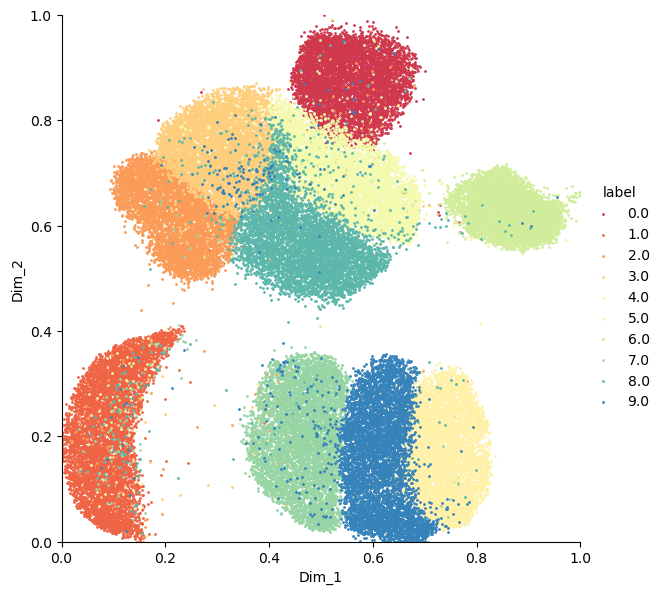

In [11]:
# save_path = os.path.join(dir_PATH, "2/")

# os.makedirs(save_path)

# for i in range(6):
#     draw_z(
#         z=normalise(outputs[i*10000:(i+1)*10000]), 
#         cls=y_train[i*10000:(i+1)*10000], 
#         s=1, 
#         save_path=os.path.join(save_path, "train_{}.png".format(i)), 
#         display=False
#     )

i = 1 #'best' # 'e59' # 1

draw_z(
        z=normalise(outputs), 
        cls=y_train, 
        s=1, 
        save_path=os.path.join(save_path, "train_{}.png".format(i)), 
        display=True
    )

In [46]:
model.MM_II.mu.view(-1)

tensor([ 0.0370, -0.0136,  0.1021,  0.0235,  0.1157, -0.0541, -0.0609, -0.0482,
        -0.0766], device='cuda:0')

In [47]:
model.MM_II.logvar.view(-1)

tensor([-0.0069, -0.0070, -0.0154, -0.0016, -0.0065, -0.0173, -0.0023, -0.0077,
        -0.0113], device='cuda:0')

In [48]:
# phase 1
pref_weights = model.MM_II.mu.view(-1) * F.tanh(model.MM_II.user_weights).view(-1)
pref_weights

tensor([-2.7872e-04, -8.3649e-05, -9.2562e-04,  2.0062e-04,  1.0337e-03,
        -1.2908e-04, -5.3180e-04,  1.0915e-03,  8.3169e-04], device='cuda:0')

In [44]:
# phase 2
pref_weights = model.MM_II.mu.view(-1) * F.tanh(model.MM_II.user_weights).view(-1)
pref_weights

tensor([-3.3299e-04, -8.4344e-05, -9.3097e-04,  2.0940e-04,  1.0246e-03,
        -1.5706e-04, -5.8072e-04,  1.1139e-03,  8.5386e-04], device='cuda:0')

In [52]:
# phase 3
pref_weights = model.MM_II.mu.view(-1) * F.tanh(model.MM_II.user_weights).view(-1)
pref_weights

tensor([-3.6325e-04, -8.6123e-05, -8.7673e-04,  1.9081e-04,  1.1086e-03,
        -3.6281e-05, -6.0487e-04,  1.1191e-03,  7.1130e-04], device='cuda:0')

# give feedback

## Global

### 1. Do you think the DR result is aesthetically pleasing?
- Human: score from 1 to 5 (ugly/dislike/okay/good/pleasant)

In [31]:
# q1 = [0, 1, 0, 0, 0]
# q1 = [0, 1, 0, 0, 0]
# q1 = [1, 0, 0, 0, 0]

# q1 = [0, 1, 0, 0, 0]
q1 = [0, 0, 1, 0, 0]

<!-- ### 2. How do you think of intervals between the clusters in DR result?
 -->
### 2. Are you satisfied with the distance or closeness between clusters?
<!-- - Human:
    - 5: all clusters are at reasonable distance from each other
    - 4: clusters are at reasonable distance in general
    - 3: 
    - 2: 
    - 1: all clusters are too far away from each other -->

- Human: scores from 1 to 5 (ugly/dislike/okay/good/pleasant)

In [32]:
# q2 = [1, 0, 0, 0, 0]
# q2 = [0, 1, 0, 0, 0]
# q2 = [1, 0, 0, 0, 0]

# q2 = [0, 1, 0, 0, 0]
q2 = [0, 1, 0, 0, 0]

### 3. Do you like the shape of these clusters?
- Human: score from 1 to 5

In [33]:
# q3 = [0, 1, 0, 0, 0]
# q3 = [0, 1, 0, 0, 0]
# q3 = [1, 0, 0, 0, 0]

# q3 = [0, 1, 0, 0, 0]
q3 = [0, 1, 0, 0, 0]

### 4. Do you like the relative positions between clusters?
- Human: score from 1 to 5

In [34]:
# q4 = [1, 0, 0, 0, 0]
# q4 = [0, 1, 0, 0, 0]
# q4 = [1, 0, 0, 0, 0]

# q4 = [0, 1, 0, 0, 0]
q4 = [0, 0, 1, 0, 0]

## Local

### 5. Heuristics ROIs

#### 5.1 Region with the highest entropy
- Do you think the DR result in this region is aesthetically pleasing?
    - Human: score from 1 to 5
- What do you think the misclassified datapoints in this region?
    - Human: It’s inspiring/It’s preferable/It’s okay/It’s not preferable/It’s intolerable



In [ ]:
# TODO

## collect answers above

In [35]:
q = [q1, q2, q3, q4]
q = torch.Tensor(q)
q, q.shape

(tensor([[0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.]]),
 torch.Size([4, 5]))

In [36]:
# save_pathq = "./results/231016000038_I_0/feedback.pt"
# save_pathq = "./results/231017152222_I_1/feedback.pt"
# save_pathq = "./results/231017170524_I_2/feedback.pt"

# save_pathq = "./results/231024172445/1/feedback.pt"

# save_pathq = "./results/231031212002/feedback_1.pt"
save_pathq = "./results/231031212002/feedback_2.pt"
torch.save(q, save_pathq)

q = torch.load(save_pathq)
q

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])